## 데이터 병합

In [3]:
import pandas as pd
import glob
import os

In [4]:
os.chdir('/home1/gkrtod35/ISF/TimeGAN/Origin_data')

In [16]:
# solar_seoul.xlsx 읽기
solar_df = pd.read_csv('solar_seoul.csv')

# weather 폴더의 파일 읽기
weather_df = pd.read_csv('weather_seoul.csv')

# 날씨 데이터의 날짜/시간 컬럼 처리
weather_df['datetime'] = pd.to_datetime(weather_df['일시'])
weather_df['date'] = weather_df['datetime'].dt.date
weather_df['time'] = weather_df['datetime'].dt.hour

# solar_seoul.csv의 날짜 형식 변환
solar_df['date'] = pd.to_datetime(solar_df['date']).dt.date

# 두 데이터셋 병합
merged_df = pd.merge(solar_df, weather_df, on=['date', 'time'], how='inner')

# 결과 저장
merged_df.to_csv('merged_data_seoul.csv', index=False)
print("데이터 병합이 완료되었습니다.") 

데이터 병합이 완료되었습니다.


## 전처리

In [11]:
import pandas as pd
import numpy as np # numpy 추가

df = merged_df
columns_to_drop = ["지점", "강수량(mm)", "3시간신적설(cm)", "운형(운형약어)",
                   "최저운고(100m )", "시정(10m)", "지면상태(지면상태코드)",
                   "현상번호(국내식)", "datetime"]
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_columns_to_drop, inplace=True)

columns_to_fill_zero = [
    '일조(hr)',
    '일사(MJ/m2)',
    '적설(cm)',
    '전운량(10분위)',
    '중하층운량(10분위)'
]

print("--- 0으로 결측치 채우기 ---")
filled_count_zero = 0
for col in columns_to_fill_zero:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        original_nan_count = df[col].isnull().sum()
        if original_nan_count > 0:
            df[col] = df[col].fillna(0)
            filled_count_zero += original_nan_count
            print(f"컬럼 '{col}': 결측치 {original_nan_count}개를 0으로 채웠습니다.")
        else:
            print(f"컬럼 '{col}': 결측치가 없습니다.")
    else:
        print(f"주의: 컬럼 '{col}'이(가) 파일에 존재하지 않습니다.")

print(f"\n총 {filled_count_zero}개의 결측치를 0으로 채웠습니다.\n")



columns_to_interpolate = [
    '기온(°C)',
    '풍속(m/s)',
    '풍향(16방위)', # 풍향은 순환적 특성 고려 시 다른 방법이 더 좋을 수 있으나, 일단 선형 보간 적용
    '습도(%)',
    '증기압(hPa)',
    '이슬점온도(°C)',
    '현지기압(hPa)',
    '해면기압(hPa)',
    '지면온도(°C)',
    '5cm 지중온도(°C)',
    '10cm 지중온도(°C)',
    '20cm 지중온도(°C)',
    '30cm 지중온도(°C)'
]

print("--- 선형 보간법으로 결측치 채우기 ---")
filled_count_interp = 0
for col in columns_to_interpolate:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        original_nan_count = df[col].isnull().sum()
        if original_nan_count > 0:
            
            df[col] = df[col].interpolate(method='linear', limit_direction='both')
            remaining_nan = df[col].isnull().sum()
            if remaining_nan > 0:
                 print(f"컬럼 '{col}': {remaining_nan} -> 0")
                 df[col] = df[col].fillna(0)

            filled_this_col = original_nan_count - remaining_nan
            filled_count_interp += filled_this_col
            print(f"컬럼 '{col}': 결측치 {filled_this_col}개를 선형 보간법으로 채웠습니다.")
        else:
             print(f"컬럼 '{col}': 결측치가 없습니다.")
    else:
        print(f"주의: 컬럼 '{col}' isn't exist.")

print(f"\n총 {filled_count_interp}개의 결측치 -> value with interpolation.\n")


# 최종 결측치 확인
print("--- 최종 결측치 확인 ---")
print(df.isnull().sum())

# 처리된 데이터프레임 확인 (선택 사항)
# print(df.head())

--- 0으로 결측치 채우기 ---
컬럼 '일조(hr)': 결측치 39360개를 0으로 채웠습니다.
컬럼 '일사(MJ/m2)': 결측치 39548개를 0으로 채웠습니다.
컬럼 '적설(cm)': 결측치 84355개를 0으로 채웠습니다.
컬럼 '전운량(10분위)': 결측치 8853개를 0으로 채웠습니다.
컬럼 '중하층운량(10분위)': 결측치 5188개를 0으로 채웠습니다.

총 177304개의 결측치를 0으로 채웠습니다.

--- 선형 보간법으로 결측치 채우기 ---
컬럼 '기온(°C)': 결측치 6개를 선형 보간법으로 채웠습니다.
컬럼 '풍속(m/s)': 결측치 55개를 선형 보간법으로 채웠습니다.
컬럼 '풍향(16방위)': 결측치 55개를 선형 보간법으로 채웠습니다.
컬럼 '습도(%)': 결측치 21개를 선형 보간법으로 채웠습니다.
컬럼 '증기압(hPa)': 결측치 14개를 선형 보간법으로 채웠습니다.
컬럼 '이슬점온도(°C)': 결측치 19개를 선형 보간법으로 채웠습니다.
컬럼 '현지기압(hPa)': 결측치 20개를 선형 보간법으로 채웠습니다.
컬럼 '해면기압(hPa)': 결측치 17개를 선형 보간법으로 채웠습니다.
컬럼 '지면온도(°C)': 결측치 69개를 선형 보간법으로 채웠습니다.
컬럼 '5cm 지중온도(°C)': 결측치 74개를 선형 보간법으로 채웠습니다.
컬럼 '10cm 지중온도(°C)': 결측치 69개를 선형 보간법으로 채웠습니다.
컬럼 '20cm 지중온도(°C)': 결측치 85개를 선형 보간법으로 채웠습니다.
컬럼 '30cm 지중온도(°C)': 결측치 159개를 선형 보간법으로 채웠습니다.

총 663개의 결측치 -> value with interpolation.

--- 최종 결측치 확인 ---
date                0
time                0
solar generation    0
일시                  0
기온(°C)              0
풍속(m/s)             0
풍향(16방위)

In [12]:
# 2) 윈도우 사이즈 정의
window_size = 24

# 3) Idx 컬럼 생성: 0,0,…(24번),1,1,…(24번),2,… 
df.insert(
    0,                          # 맨 앞에 삽입
    "Idx",                      # 컬럼명
    np.arange(len(df)) // window_size   # 0,0…//24 =0, 24//24=1, …
)

# 4) 확인
print(df.head(30))

    Idx        date  time solar generation                일시  기온(°C)  풍속(m/s)  \
0     0  2014-01-01     0              0.0  2014-01-01 00:00     3.3      3.8   
1     0  2014-01-01     1              0.0  2014-01-01 01:00     2.6      2.3   
2     0  2014-01-01     2              0.0  2014-01-01 02:00     1.7      1.7   
3     0  2014-01-01     3              0.0  2014-01-01 03:00     1.4      1.4   
4     0  2014-01-01     4              0.0  2014-01-01 04:00     0.9      2.8   
5     0  2014-01-01     5              0.0  2014-01-01 05:00     0.6      2.0   
6     0  2014-01-01     6              0.0  2014-01-01 06:00     0.7      2.3   
7     0  2014-01-01     7              0.0  2014-01-01 07:00     0.7      1.7   
8     0  2014-01-01     8         0.235514  2014-01-01 08:00     0.5      1.6   
9     0  2014-01-01     9         0.887101  2014-01-01 09:00     1.8      2.3   
10    0  2014-01-01    10         0.920795  2014-01-01 10:00     3.6      2.9   
11    0  2014-01-01    11   

In [17]:
# solar generation에서 빈 문자열로 들어있는 경우 0을 채울 수 없는 경우가 발생
mask_space = df['solar generation'].apply(
    lambda x: isinstance(x, str) and x.strip() == ''
)
print("공백만 있는 행들:")
print(df[mask_space])

공백만 있는 행들:
Empty DataFrame
Columns: [Idx, date, time, solar generation, 일시, 기온(°C), 풍속(m/s), 풍향(16방위), 습도(%), 증기압(hPa), 이슬점온도(°C), 현지기압(hPa), 해면기압(hPa), 일조(hr), 일사(MJ/m2), 적설(cm), 전운량(10분위), 중하층운량(10분위), 지면온도(°C), 5cm 지중온도(°C), 10cm 지중온도(°C), 20cm 지중온도(°C), 30cm 지중온도(°C)]
Index: []

[0 rows x 23 columns]


In [31]:
# 공백만 있는 셀 마스크
mask_space = df['solar generation'].apply(lambda x: isinstance(x, str) and x.strip() == '')

# 해당 위치를 0으로 대체
df.loc[mask_space, 'solar generation'] = 0

In [33]:
# 필요하다면 처리된 데이터프레임 저장
df.to_csv('merged_data_processed_seoul.csv', index=False, encoding='utf-8')
# print("\n처리된 데이터를 'merged_data_processed.csv'로 저장했습니다.")

In [19]:
import matplotlib.pyplot as plt

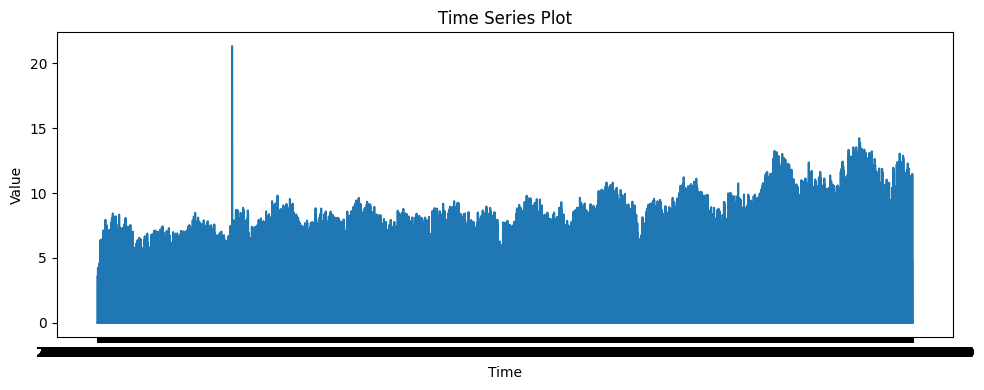

In [30]:
plt.figure(figsize=(10, 4))         # 그림 크기 설정 (가로10인치 × 세로4인치)
plt.plot(df['일시'], df['solar generation'])   
plt.xlabel('Time')                  # x축 라벨
plt.ylabel('Value')                 # y축 라벨
plt.title('Time Series Plot')       # 그래프 제목
plt.tight_layout()                  # 레이아웃 자동 조정
plt.show()